[Jump to where I left off](#contd)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
%matplotlib inline

In [2]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In this notebook, I implement the chlorophyll algorithms discussed earlier using a Bayesian framework, which will allow inter-model predictive skill comparison using Information Theory. For each model, implementation follows the sequence below:

* The model is cast in a Bayesian framework using a probabilistic programming language (PPL);
* A set of prior predictive simulations is conducted to ascertain that model priors are reasonable;
* The model is fit using the No U-Turn Sampler (NUTS) variant of Hamiltonian Monte Carlo, and the data subset from NOMAD 2008;
* Model predictive skill and  uncertainty are quantified via posterior distribution evaluation and posterior predictive simulation;
* Inter-model comparisons of model skill are conducted using Information Criteria (IC) including Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave One Out Cross Validation (LOO). This step 

1. Implementation of $OC_4$
    
    <font color=red>a. pooled model - the data is used as is for a single regressiom model</font>
    
    b. partially pooled model - the data is grouped according to the blue band used in the ratio

In [3]:
df_log = pd.read_pickle('./pickleJar/df_log_nopurple_nored_with_MBR.pkl')

In [4]:
df_log.head()

,id,log_rrs443,log_rrs489,log_rrs510,log_rrs555,MaxBlueBand,MaxBlueBandIdx,log_mxBlue2Gr,log_chlor_a,is_hplc
0,1565,-2.773122,-2.482397,-2.394012,-2.126145,Rrs510,2,-0.267867,1.581950,False
1,1566,-2.858857,-2.662956,-2.602191,-2.381734,Rrs510,2,-0.220457,1.544192,False
2,1567,-2.926105,-2.734427,-2.640597,-2.372060,Rrs510,2,-0.268537,1.429914,False
3,1568,-2.759143,-2.541014,-2.436014,-2.156039,Rrs510,2,-0.279976,1.680879,False
4,1559,-2.990409,-2.822196,-2.720468,-2.552735,Rrs510,2,-0.167733,1.371991,False


In [5]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 10 columns):
id                4459 non-null int64
log_rrs443        4456 non-null float64
log_rrs489        4422 non-null float64
log_rrs510        3435 non-null float64
log_rrs555        3255 non-null float64
MaxBlueBand       4459 non-null object
MaxBlueBandIdx    4459 non-null int8
log_mxBlue2Gr     3255 non-null float64
log_chlor_a       4127 non-null float64
is_hplc           4459 non-null bool
dtypes: bool(1), float64(6), int64(1), int8(1), object(1)
memory usage: 287.5+ KB


In [6]:
df_log_small = df_log[['log_mxBlue2Gr', 'MaxBlueBandIdx', 'log_chlor_a']].dropna()
X_oc4 = df_log_small.log_mxBlue2Gr.values
y = df_log_small.log_chlor_a.values
X_poly = np.c_[X_oc4, np.power(X_oc4, 2), np.power(X_oc4, 3), np.power(X_oc4, 4)]

In [7]:
X_poly.shape

(2972, 4)

Writing $OC_4$ as a Bayesian regression model takes the following form

In [8]:
with pm.Model() as m_oc4:
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=X_poly.shape[1])
    σ = pm.Exponential('σ', 1)
    μ =  α + pm.math.dot(X_poly, β)
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y)

In [9]:
render = pm.model_to_graphviz(m_oc4)

In [10]:
render.format='png'
render.render('m_oc4_pooled', directory='./figJar');

<center><h3>Pooled Bayesian $OC_4$ polynomial regression model</h3></center>
<img src='./figJar/m_oc4_pooled.png?:0' />
<br><br>
<h3>Prior predictive sampling for sanity checks on priors</h3>

In [11]:
m_oc4_priors = pm.sample_prior_predictive(model=m_oc4,)

In [12]:
log_chl_prior = m_oc4_priors['log_chl']

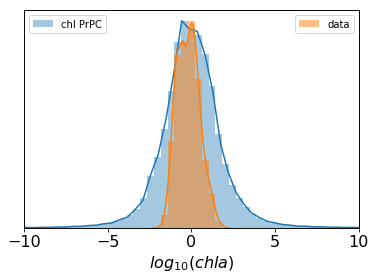

In [13]:
f, ax = pl.subplots(figsize=(6, 4))
sb.distplot(log_chl_prior.flatten(), bins=np.linspace(-10, 10),
            label='chl PrPC', ax=ax)
ax.set_xlim(-10, 10)
ax2 = ax.twinx()
##sb.distplot(log_chl_prior.flatten(), label=)
sb.distplot(y, bins=np.linspace(-10 ,10,), hist_kws={'alpha': 0.5, 'color': 'C1'},
            kde_kws={'color': 'C1',}, ax=ax2, label='data')
ax.legend(loc='upper left')
ax2.legend();
ax.set_yticks([])
ax2.set_yticks([])
ax.set_xlabel('$log_{10}(chl a)$')
f.savefig('./figJar/m_oc4_pooled_prior_predictive_check.png', dpi=300)

The above shows that the model priors are constrained so as to give very little credibility to unrealistic values of chlorophyll.
<h3>Model fit and analysis of results</h3>

In [14]:
with m_oc4:
    trace_oc4 = pm.sample(2000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:56<00:00, 123.08draws/s]


In [16]:
#m_oc4_posteriors = {k: trace_oc4.get_values(k) for k in ['α', 'β', 'σ']}
posterior_predictive_oc4 = pm.sample_posterior_predictive(trace_oc4, 500, m_oc4)

100%|██████████| 500/500 [00:00<00:00, 908.90it/s]


In [24]:
inference_data_oc4 = ar.from_pymc3(trace=trace_oc4,
                                   #prior=m_oc4_priors,
                                   posterior_predictive=posterior_predictive_oc4)

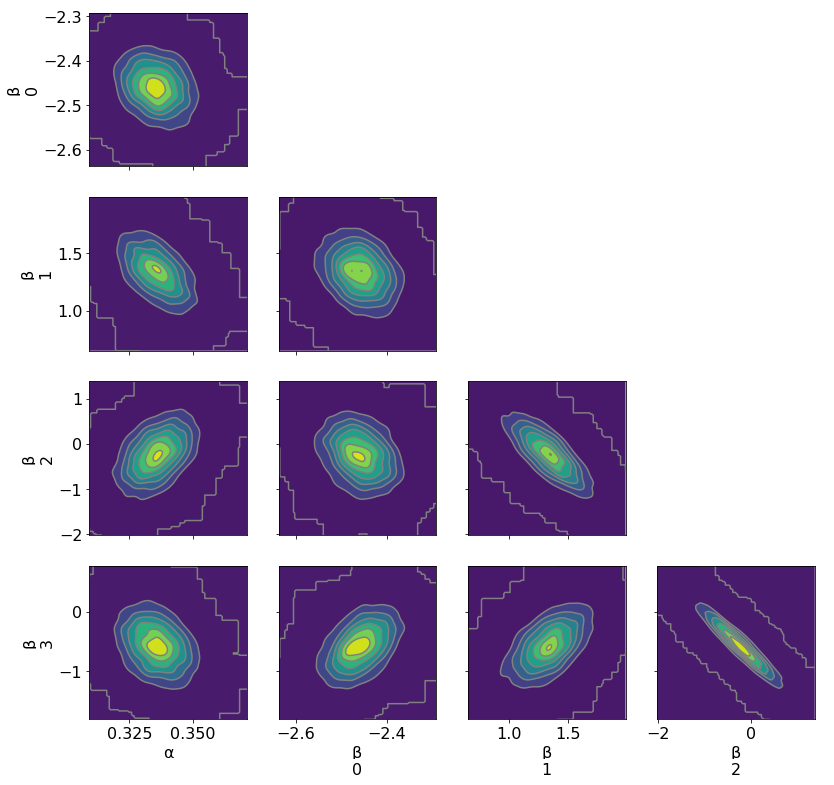

In [31]:
f, axs = pl.subplots(ncols=4, nrows=4, figsize=(13, 13))
ar.plot_pair(inference_data_oc4, var_names=['α', 'β'], kind='kde', divergences=True,
            textsize=16, ax=axs);
#f = pl.gcf()
#f.savefig('./figJar/m_oc4_pooled_pairwise_param.png', dpi=300)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x123eca898>],
      dtype=object)

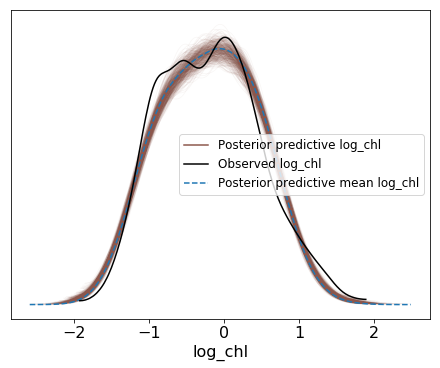

In [36]:
ax = ar.plot_ppc(inference_data_oc4, alpha=0.05, textsize=16, figsize=(6, 5));

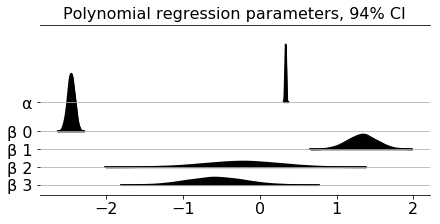

In [47]:
f, axs = ar.plot_forest(inference_data_oc4, kind='ridgeplot', var_names=['α', 'β'],
                         combined=True, ridgeplot_overlap=8, colors='k', figsize=(6, 3),
                       textsize=16)
axs[0].set_title('Polynomial regression parameters, 94% CI', fontsize=16)
axs[0].grid(axis='y')

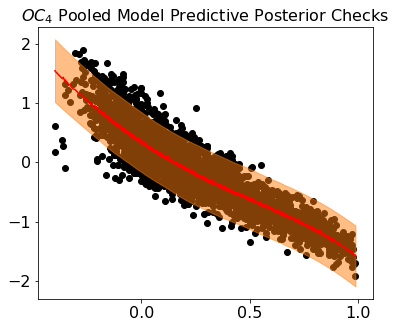

In [60]:
f, ax = pl.subplots(figsize=(6, 5))
idx = X_oc4.argsort()
ax.scatter(X_oc4, y, color='k',)
ar.plot_hpd(X_oc4, posterior_predictive_oc4['log_chl'], ax=ax)
ax.plot(X_oc4[idx], posterior_predictive_oc4['log_chl'].mean(axis=0)[idx], color='r');
ax.set_title('$OC_4$ Pooled Model Predictive Posterior Checks', fontsize=16);
f.savefig('./figJar/m_oc4_pooled_posterior_predictive_check.png', dpi=300)

<a id='contd'></a>
### 1. Implementation of $OC_4$
    
   #### ~~a. pooled model - the data is used as is for a single regressiom model~~
   <h4><font color=red> b. partially pooled model - the data is grouped according to the blue band used in the MBR</font></h4>



# Get grouping index

In [ ]:
with pm.Model() as m_oc4_pp:
    

2. Implementation of $OC_x$ with $CI$ split


    A. Without chlorophyll measurement error

In [ ]:
with pm.Model() as m_oci:
    \alpha

    B. With chlorophyll measurement error

3. Simple band ratio

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

4. Multivariate Linear Regression


    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

5. Multivariate Linear Regression with Prior Transformation of Principal Components of Reflectance

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error